# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2019 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Regresszió mély tanulással

Ebben a notebookban a gépi tanulás egyik "Hello world"-jét fogjuk megismeri. Ehhez a Boston Housing Prices adatbázist fogjuk felhasználni. 

Az adatbázis formátumának leírását itt találjuk: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
Magát az adatbázist pedig innen tölthetjük le: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data

Töltsük le az utóbbi CSV fájlt és mentsük a jelenlegi Python forrás / notebook mellé.

Következő lépésként importáljuk a szükséges modulokat és állítsunk be egy random seed-et:

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import copy
import pandas as pd
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler


np.random.seed(123)

Using TensorFlow backend.


Ezután töltsük le és töltsük be az adatokat, válasszuk szét a train-validation-test adathalmazokat és standardizáljuk a bemeneteket:

In [2]:
import urllib.request
urllib.request.urlretrieve ("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data", "housing.data")

('housing.data', <http.client.HTTPMessage at 0xe1bcfd0>)

In [3]:
df = pd.read_csv("housing.data", delim_whitespace=True, header=None)
dataset = df.values
test_split = 0.1
valid_split = 0.1

X = dataset[:,0:13]
Y = dataset[:,13]

v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X = X[:v_index]
Y = Y[:v_index]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


Ezt követően adjuk meg a callback függvényeket:

In [4]:
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

És hozzuk létre a hálót és tanítsuk be:

In [5]:
model = Sequential()
model.add(Dense(output_dim=60, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=1, activation='linear'))

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)
history=model.fit(X,Y,epochs=10000, 
                  batch_size=16,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[checkpointer, early_stopping])

C:\Users\Balint\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=13, units=60)`
  
C:\Users\Balint\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  """


Train on 404 samples, validate on 51 samples
Epoch 1/10000
 - 0s - loss: 171.5212 - val_loss: 34.6719

Epoch 00001: val_loss improved from inf to 34.67189, saving model to weights.hdf5
Epoch 2/10000
 - 0s - loss: 42.4264 - val_loss: 22.1017

Epoch 00002: val_loss improved from 34.67189 to 22.10172, saving model to weights.hdf5
Epoch 3/10000
 - 0s - loss: 36.7255 - val_loss: 28.9371

Epoch 00003: val_loss did not improve from 22.10172
Epoch 4/10000
 - 0s - loss: 40.1212 - val_loss: 20.5489

Epoch 00004: val_loss improved from 22.10172 to 20.54887, saving model to weights.hdf5
Epoch 5/10000
 - 0s - loss: 32.0560 - val_loss: 29.9781

Epoch 00005: val_loss did not improve from 20.54887
Epoch 6/10000
 - 0s - loss: 32.4057 - val_loss: 30.0586

Epoch 00006: val_loss did not improve from 20.54887
Epoch 7/10000
 - 0s - loss: 30.4954 - val_loss: 25.0362

Epoch 00007: val_loss did not improve from 20.54887
Epoch 8/10000
 - 0s - loss: 31.4053 - val_loss: 38.0468

Epoch 00008: val_loss did not impr

A tanítás végeztével visszatöltjük a legjobb modellt, és kiértékeljük ennek teljesítményét a teszt adatokon. Mit jelenthet ez az érték?

In [6]:
model = load_model('weights.hdf5')

from sklearn.metrics import mean_squared_error
model = load_model('weights.hdf5')
preds = model.predict(X_test)
test_err = mean_squared_error(Y_test,preds)
print("\nTeszt hiba: %f" % (test_err))


Teszt hiba: 12.169046


Tehát ez az jelenti, hogy sqrt(12.17)=3.488-at hibáz átlagosan a modell a teszt adatokon. És annyit jelent, hogy átlagosan 3488$-t téved a modellünk.

Az eredményeket vizsgáljuk meg grafikusan is:

C:\Users\Balint\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


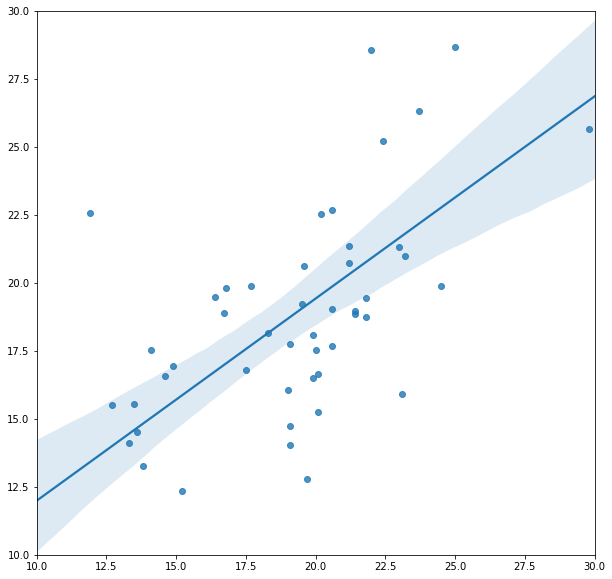

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.regplot(x=Y_test, y=preds.reshape(-1)).set(xlim=(10,30),ylim=(10,30));

Mit jelent ez az ábra? Mit jelentene egy vízszintes egyenes? És egy függőleges egyenes?